<div>
<img src="img/Princeton%20logo.png" width="150" align="right"/>
</div>

<div>
<img src="img/IRIS-HEP%20logo.png" width="120" align="left"/>
</div>

<br>
<br>
<br>
<br>

# Awkward RDataFrame Status
### Ianna Osborne, Jim Pivarski 
*Princeton University*


<div>
<img src="img/NSF%20logo.png" width="50" align="left"/>
</div>

#### OAC-1836650

## Awkward Array and RDataFrame

- Awkward Array and RDataFrame are two very different ways of performing calculations at scale

    - [Awkward Array](https://github.com/scikit-hep/awkward) is a library for nested, variable-sized data, including arbitrary-length lists, records, mixed types, and missing data, using NumPy-like idioms

    - [RDataFrame](https://root.cern.ch/doc/master/classROOT_1_1RDataFrame.html) - [ROOT](https://root.cern.ch/doc/master/namespaceROOT.html)'s declarative analysis interface 
        - supports many input formats

- The Awkward-RDataFrame bridge provides users with more flexibility in mixing different packages and languages in their analyses. There are numerous benefits of combining both Python and C++. Physicists can mix analyses using Awkward Arrays, Numba, and ROOT C++ in memory, without saving to disk and without leaving their environment.

## Awkward Array and other projects

<div>
<img src="img/Awkward%20Array%20and%20other%20projects.png" width="800" align="center"/>
</div>

- See Jim's talk [Uproot, Awkward Array, hist, Vector: from basics to combinatorics](https://github.com/jpivarski-talks/2022-09-12-pyhep22-awkward-combinatorics/blob/main/pyhep2022-combinatorics.ipynb)
- See Saransh's talk [Constructing HEP vectors and analyzing HEP data using Vector](https://github.com/Saransh-cpp/PyHEP22-Constructing-HEP-vectors-and-analyzing-HEP-data-using-Vector)
- See Doug's [Dask Tutorial]() 
- See Kush's [Uproot + Dask]() 
- [This tutorial](https://github.com/ianna/PyHep2022) covers Awkward Arrays <--> RDataFrame

## From Awkward Array to RDataFrame
### View
* Awkward Arrays are already JIT-compiled with Numba. Here we are reusing some of the Numba implementation for C++: no performance difference
* The `ak.to_rdataframe` function presents a view of a Python Awkward Array as an RDataFrame source
* This view is generated on demand and the data is not copied
* The column readers are generated based on the run-time type of the views
* The readers are passed to a generated source derived from ROOT::RDF::RDataSource

```python
            self.data_ptrs_list.append(self.lookups[key].arrayptrs.ctypes.data)

            cpp_code_declare_slots = (
                cpp_code_declare_slots
                + f"""
        ULong64_t fPtrs_{key} = 0;
        std::vector<{self.entry_types[key]}>  slots_{key};
        std::vector<{self.entry_types[key]}*> addrs_{key};
    """
            )

            cpp_code_define_readers = (
                cpp_code_define_readers
                + f"""
        if (name == "{key}") {{
            for (auto i : ROOT::TSeqU(fNSlots)) {{
                addrs_{key}[i] = &slots_{key}[i];
                reader.emplace_back((void *)(&addrs_{key}[i]));
            }}
        }}
    """

```

### Data Source
* Generated AwkwardArray RDataSource takes pointers into the original array data: a 40-byte ArrayView object is allocated on the stack
* Array view is a cursor:
<div>
<img src="img/cursor.png" width="700" align="center"/>
</div>


* The large-scale array data are not copied
* The views are transient, their lifetime is defined by the lifetime of their lookup Python object
  * A base class of all Array Views holds a pointer to a lookup Python object

```c++
  class ArrayView {
  public:
    ArrayView(ssize_t start, ssize_t stop, ssize_t which, ssize_t* ptrs, PyObject* lookup)
      : start_(start), stop_(stop), which_(which), ptrs_(ptrs), lookup_(lookup) {
      }

    size_t size() const noexcept {
      return stop_ - start_;
    }

    bool empty() const noexcept {
      return start_ == stop_;
    }

    PyObject* lookup() {
        Py_INCREF(lookup_);
        return lookup_;
    }

  protected:
    ssize_t start_;
    ssize_t stop_;
    ssize_t which_;
    ssize_t* ptrs_;
    PyObject* lookup_;
  };
```

* ArrayViews keep a pointer to their lookup Python object to facilitate a no-copy conversion back to an Awkward Array

### From Python to C++
#### from C++ back to Python and to C++ again
* C++ code generated from Python and fed to Cling
  * Let's look at an example of a generated `ListArray` view for an `ak.Array([[1.1, 2.2], [3.3], … []])` - e.g. nested `NumpyArray`s.
    * Note, the `value_type` is requested to be `ROOT::VecOps::RVec<double>`, though native type is: 
    
    ```c++
typedef NumpyArray_float64_IeMUCd8nMJU value_type;
    ```

```c++
namespace awkward {
  class ListArray_Cj7Qec8BHPk: public ArrayView {
  public:
    ListArray_Cj7Qec8BHPk(ssize_t start, ssize_t stop, ssize_t which, ssize_t* ptrs, PyObject* lookup)
      : ArrayView(start, stop, which, ptrs, lookup) { }
    ListArray_Cj7Qec8BHPk() : ArrayView(0, 0, 0, 0, 0) { }

    typedef ROOT::VecOps::RVec<double> value_type;

    const std::string parameter(const std::string& parameter) const noexcept {
      return "null";
    }

    bool operator==(ListArray_Cj7Qec8BHPk other) const noexcept {
      return start_ == other.start_  &&
             stop_ == other.stop_  &&
             which_ == other.which_  &&
             ptrs_ == other.ptrs_;
    }

    bool operator!=(ListArray_Cj7Qec8BHPk other) const noexcept {
      return start_ != other.start_  ||
             stop_ != other.stop_  ||
             which_ != other.which_  ||
             ptrs_ != other.ptrs_;
    }

    Iterator<ListArray_Cj7Qec8BHPk, value_type> begin() const noexcept {
      return Iterator<ListArray_Cj7Qec8BHPk, value_type>(start_, stop_, which_, ptrs_, lookup_);
    }

    Iterator<ListArray_Cj7Qec8BHPk, value_type> end() const noexcept {
      return Iterator<ListArray_Cj7Qec8BHPk, value_type>(stop_, stop_, which_, ptrs_, lookup_);
    }

    RIterator<ListArray_Cj7Qec8BHPk, value_type> rbegin() const noexcept {
      return RIterator<ListArray_Cj7Qec8BHPk, value_type>(stop_ - 1, stop_, which_, ptrs_, lookup_);
    }

    RIterator<ListArray_Cj7Qec8BHPk, value_type> rend() const noexcept {
      return RIterator<ListArray_Cj7Qec8BHPk, value_type>(start_ - 1, stop_, which_, ptrs_, lookup_);
    }

    value_type operator[](size_t at) const noexcept {
      ssize_t start = reinterpret_cast<int64_t*>(ptrs_[which_ + 1])[start_ + at];
      ssize_t stop = reinterpret_cast<int64_t*>(ptrs_[which_ + 2])[start_ + at];
      ssize_t which = ptrs_[which_ + 3];
      double* content = reinterpret_cast<double*>(ptrs_[which + 1]) + start;
      return value_type(content, stop - start);
    }
  };
}
```

* The Awkward Array <--> RDataFrame is a part of Awkward Array version 2, which is currently a master branch:

In [1]:
import awkward as ak
import ROOT

Welcome to JupyROOT 6.26/06


In [2]:
ak.__version__

'2.0.0rc1'

In [3]:
array_x = ak.Array(
        [
            {"x": [1.1, 1.2, 1.3]},
            {"x": [2.1, 2.2]},
            {"x": [3.1]},
            {"x": [4.1, 4.2, 4.3, 4.4]},
            {"x": [5.1]},
        ]
    )
array_y = ak.Array([1, 2, 3, 4, 5])
array_z = ak.Array([[1.1], [2.1, 2.3, 2.4], [3.1], [4.1, 4.2, 4.3], [5.1]])

In [4]:
array_x.show(type=True)

type: 5 * {
    x: var * float64
}
[{x: [1.1, 1.2, 1.3]},
 {x: [2.1, 2.2]},
 {x: [3.1]},
 {x: [4.1, 4.2, 4.3, 4.4]},
 {x: [5.1]}]


In [5]:
array_y.show(type=True)

type: 5 * int64
[1,
 2,
 3,
 4,
 5]


In [6]:
array_z.show(type=True)

type: 5 * var * float64
[[1.1],
 [2.1, 2.3, 2.4],
 [3.1],
 [4.1, 4.2, 4.3],
 [5.1]]


## `ak.to_rdataframe` function

- The awkward style `ak.to_rdataframe` function requires a dictionary: 
    - each - unique - key defines a column name in RDataFrame
    - the arrays given for each column have to be equal length
- There is a small overhead of generating [Awkward RDataSource C++ code](https://github.com/scikit-hep/awkward/blob/main/src/awkward/_v2/_connect/rdataframe/to_rdataframe.py#L152-L252)
    - This operation does not execute the RDF event loop
    - The array data are not copied

In [7]:
assert len(array_x) == len(array_y) == len(array_z)

In [8]:
df = ak.to_rdataframe({"x": array_x, "y": array_y, "z": array_z})

In [9]:
df.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            4
Columns from defines        1
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
awkward_index_  Long64_t                        Define
x               awkward::Record_eTuI5KazfpM     Dataset
y               int64_t                         Dataset
z               ROOT::VecOps::RVec<double>      Dataset

* The `x` column contains an Awkward Array with a made-up type; `awkward::Record_cKnX5DyNVM`.

* Awkward Arrays are dynamically typed, so in a C++ context, the type name is hashed. In practice, there is no need to know the type. The C++ code should use a placeholder type specifier `auto`. The type of the variable that is being declared will be automatically deduced from its initializer.

* The `awkward_index_` column is always defined; it is used internally. 

## Columns type

In [10]:
df.GetColumnType("x")

'awkward::Record_eTuI5KazfpM'

In [11]:
df.GetColumnType("y")

'int64_t'

In [12]:
df.GetColumnType("z")

'ROOT::VecOps::RVec<double>'

## Operations on data in RDataFrame
* Scheduling a filtering operation does not execute the event loop.

In [13]:
df = df.Filter("y > 2")

* Let's check the state of the dataframe to make sure that the event loop was not triggered.

In [14]:
df.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            4
Columns from defines        1
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
awkward_index_  Long64_t                        Define
x               awkward::Record_eTuI5KazfpM     Dataset
y               int64_t                         Dataset
z               ROOT::VecOps::RVec<double>      Dataset

## Retrieve selected columns

* The *`ak.from_rdataframe`* function converts selected columns to native Awkward Arrays.

* The function takes a tuple of strings that are the RDF column names.

* The event loop is triggered once to retrieve all selected columns.

In [15]:
out = ak.from_rdataframe(
    df,
    columns=("x", "y", "z",),
)

In [16]:
out

<Array [{y: 3, z: [3.1], x: {...}}, ..., {...}] type='3 * {y: int64, z: var...'>

## Filtered array type
Let's check the type of the Awkward Array:

In [17]:
out.show(type=True)

type: 3 * {
    y: int64,
    z: var * float64,
    x: {
        x: var * float64
    }
}
[{y: 3, z: [3.1], x: {x: [3.1]}},
 {y: 4, z: [4.1, 4.2, 4.3], x: {x: [4.1, ...]}},
 {y: 5, z: [5.1], x: {x: [5.1]}}]


Let's check the filtered entries for `y > 2`:

In [18]:
print(out["y"].to_list())
print(out["z"].to_list())
print(out["x"].to_list())

[3, 4, 5]
[[3.1], [4.1, 4.2, 4.3], [5.1]]
[{'x': [3.1]}, {'x': [4.1, 4.2, 4.3, 4.4]}, {'x': [5.1]}]


Check to make sure we triggered the event loop only once:

In [19]:
df.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            4
Columns from defines        1
Event loops run             1
Processing slots            1

Column          Type                            Origin
------          ----                            ------
awkward_index_  Long64_t                        Define
x               awkward::Record_eTuI5KazfpM     Dataset
y               int64_t                         Dataset
z               ROOT::VecOps::RVec<double>      Dataset

## Layout details
The `RecordArray` data: its content `NumpyArray` - is not copied, it is indexed: it is wrapped in an `IndexedArray` - because of the filter selection. The other two columns data are copied.

In [20]:
out.layout

<RecordArray is_tuple='false' len='3'>
    <content index='0' field='y'>
        <NumpyArray dtype='int64' len='3'>[3 4 5]</NumpyArray>
    </content>
    <content index='1' field='z'>
        <ListOffsetArray len='3'>
            <offsets><Index dtype='int64' len='4'>
                [0 1 4 5]
            </Index></offsets>
            <content><NumpyArray dtype='float64' len='5'>[3.1 4.1 4.2 4.3 5.1]</NumpyArray></content>
        </ListOffsetArray>
    </content>
    <content index='2' field='x'>
        <IndexedArray len='3'>
            <index><Index dtype='int64' len='3'>[2 3 4]</Index></index>
            <content><RecordArray is_tuple='false' len='5'>
                <content index='0' field='x'>
                    <ListArray len='5'>
                        <starts><Index dtype='int64' len='5'>
                            [ 0  3  5  6 10]
                        </Index></starts>
                        <stops><Index dtype='int64' len='5'>
                            [ 3  5  

## The same operation on Awkward arrays in Python

- Is the array type as expected? Yes.
- Is its layout the same? No. Awkward arrays are immutable.

In [21]:
array_yzx = ak.Array({"y": array_y, "z": array_z, "x": array_x})
filtered_array = array_yzx[array_yzx["y"] > 2]
filtered_array.show(type=True)

type: 3 * {
    y: int64,
    z: var * float64,
    x: {
        x: var * float64
    }
}
[{y: 3, z: [3.1], x: {x: [3.1]}},
 {y: 4, z: [4.1, 4.2, 4.3], x: {x: [4.1, ...]}},
 {y: 5, z: [5.1], x: {x: [5.1]}}]


In [22]:
filtered_array.layout

<IndexedArray len='3'>
    <index><Index dtype='int64' len='3'>
        [2 3 4]
    </Index></index>
    <content><RecordArray is_tuple='false' len='5'>
        <content index='0' field='y'>
            <NumpyArray dtype='int64' len='5'>[1 2 3 4 5]</NumpyArray>
        </content>
        <content index='1' field='z'>
            <ListOffsetArray len='5'>
                <offsets><Index dtype='int64' len='6'>
                    [0 1 4 5 8 9]
                </Index></offsets>
                <content><NumpyArray dtype='float64' len='9'>
                    [1.1 2.1 2.3 2.4 3.1 4.1 4.2 4.3 5.1]
                </NumpyArray></content>
            </ListOffsetArray>
        </content>
        <content index='2' field='x'>
            <RecordArray is_tuple='false' len='5'>
                <content index='0' field='x'>
                    <ListOffsetArray len='5'>
                        <offsets><Index dtype='int64' len='6'>
                            [ 0  3  5  6 10 11]
                 

## From RDataFrame to Awkward Array

The *`ak.from_rdataframe`* function converts selected columns to native Awkward Arrays. The function takes a tuple of strings that are the RDF column names and recognizes the following column data types:

- Primitive types: `integer`, `float`, `double`, `std::complex<double>`, etc.
- Lists of primitive types and the arbitrary depth nested lists of primitive types: `std::vector<double>`, `RVec<int>`, etc.
- Awkward types: run-time generated types derived from `awkward::ArrayView` or `awkward::RecordView`
  - no copy required because Awkward Arrays are immutable
<div>
<img src="img/Awkward%20types.png" width="600" align="center"/>
</div>

### Readers of an arbitrary depth nested data

* A type-specialized nested array builder is used
  * C++ template Layout builder, a header-only implementation
* The function that iterates over the nested data is generated for each column based on the column type:

```python
    def cpp_builder_type(depth, data_type):
        if depth == 1:
            return f"awkward::LayoutBuilder::Numpy<{data_type}>>"
        else:
            return (
                "awkward::LayoutBuilder::ListOffset<int64_t, "
                + cpp_builder_type(depth - 1, data_type)
                + ">"
            )

    def cpp_fill_offsets_and_flatten(depth):
        if depth == 1:
            return "\nfor (auto it : vec1) {\n" + "  builder1.append(it);\n" + "}\n"
        else:
            return (
                f"for (auto const& vec{depth - 1} : vec{depth}) "
                + "{\n"
                + f"  auto& builder{depth - 1} = builder{depth}.begin_list();\n"
                + "  "
                + cpp_fill_offsets_and_flatten(depth - 1)
                + "\n"
                + f"  builder{depth}.end_list();\n"
                + "}\n"
            )

    def cpp_fill_function(depth):
        if depth == 1:
            return (
                "template<class BUILDER, typename PRIMITIVE>\n"
                + "void\n"
                + "fill_from(BUILDER& builder, ROOT::RDF::RResultPtr<std::vector<PRIMITIVE>>& result) {"
                + "  for (auto it : result) {\n"
                + "    builder.append(it);\n"
                + "  }\n"
                + "}\n"
            )
        else:
            return (
                "template<class BUILDER, typename PRIMITIVE>\n"
                + "void\n"
                + f"fill_offsets_and_flatten{depth}(BUILDER& builder{depth}, ROOT::RDF::RResultPtr<std::vector<PRIMITIVE>>& result) "
                + "{\n"
                + f"  for (auto const& vec{depth - 1} : result) "
                + "{\n"
                + f"  auto& builder{depth - 1} = builder{depth}.begin_list();\n"
                + "  "
                + cpp_fill_offsets_and_flatten(depth - 1)
                + "\n"
                + f"  builder{depth}.end_list();\n"
                + "}\n"
                + "}\n"
            )

    is_indexed = True if "awkward_index_" in data_frame.GetColumnNames() else False
```

#### Discussion Point
* This code can handle any iterable containers
  * If we new the *provenance* the Awkward columns converted to `RVecs` we could avoid the copy

## Data analysis: from C++ to Python

In [23]:
import awkward as ak
import ROOT

In [24]:
df = ROOT.RDataFrame('Events', 'root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root')

CMS data from [CERN Open Data portal DOI:10.7483/OPENDATA.CMS.LVG5.QT81](http://opendata.web.cern.ch/record/12341) 
- This dataset contains about 60 mio. data events from the CMS detector taken in 2012 during Run B and C.
- The original AOD dataset is converted to the NanoAOD format and reduced to the muon collections.
- The dataset in the file is called <b>Events</b> and contains the following columns:
 - <b>nMuon</b>	`unsigned int`	*Number of muons in this event*
 - <b>Muon_pt</b>	`float[nMuon]`	*Transverse momentum of the muons (stored as an array of size nMuon)*
 - <b>Muon_eta</b>	`float[nMuon]`	*Pseudorapidity of the muons*
 - <b>Muon_phi</b>	`float[nMuon]`	*Azimuth of the muons*
 - <b>Muon_mass</b>	`float[nMuon]`	*Mass of the muons*
 - <b>Muon_charge</b>	`int[nMuon]`	*Charge of the muons (either 1 or -1)*

In [25]:
# Describe the state of the dataframe.
# Note that this operation is not running the event loop.
df.Describe().Print()

Dataframe from TChain Events in file root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root

Property                Value
--------                -----
Columns in total            6
Columns from defines        0
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Muon_charge     ROOT::VecOps::RVec<Int_t>       Dataset
Muon_eta        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_mass       ROOT::VecOps::RVec<Float_t>     Dataset
Muon_phi        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_pt         ROOT::VecOps::RVec<Float_t>     Dataset
nMuon           UInt_t                          Dataset

Build a small analysis studying the invariant mass of dimuon systems.
- See [ROOT tutorial](https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8py.html) for more information.

In [26]:
df = df.Filter('nMuon == 2')\
       .Filter('Muon_charge[0] != Muon_charge[1]')\
       .Define('Dimuon_mass', 'InvariantMass(Muon_pt, Muon_eta, Muon_phi, Muon_mass)')\
       .Filter('Dimuon_mass > 70')\
       .Range(1000)

- Trigger the event loop by asking for the mean of the dimuon mass:

In [27]:
print('\nApproximate mass of the Z boson: {:.2f} GeV\n'.format(
        df.Mean('Dimuon_mass').GetValue()))


Approximate mass of the Z boson: 91.44 GeV



Check that this operation triggered the event loop once

In [28]:
df.Describe().Print()

Dataframe from TChain Events in file root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root

Property                Value
--------                -----
Columns in total            7
Columns from defines        1
Event loops run             1
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Dimuon_mass     float                           Define
Muon_charge     ROOT::VecOps::RVec<Int_t>       Dataset
Muon_eta        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_mass       ROOT::VecOps::RVec<Float_t>     Dataset
Muon_phi        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_pt         ROOT::VecOps::RVec<Float_t>     Dataset
nMuon           UInt_t                          Dataset

## Convert selected columns to Awkward Array

- The scheduled analysis executed the event loop once
- A user can take the data out as an Awkward Array
- If the columns type is not `awkward`, the `ROOT::VecOps::RVec`s content is copied to a Numpy buffer

In [29]:
array = ak.from_rdataframe(
        df,
        columns=(
            "Dimuon_mass",
        ),
    )

In [30]:
array

<Array [{Dimuon_mass: 114}, {...}, ..., {...}] type='1000 * {Dimuon_mass: f...'>

## Array type

In [31]:
array.show(type=True)

type: 1000 * {
    Dimuon_mass: float32
}
[{Dimuon_mass: 114},
 {Dimuon_mass: 88.3},
 {Dimuon_mass: 88.3},
 {Dimuon_mass: 91.3},
 {Dimuon_mass: 93.6},
 {Dimuon_mass: 90.9},
 {Dimuon_mass: 89.2},
 {Dimuon_mass: 82.3},
 {Dimuon_mass: 94.6},
 {Dimuon_mass: 89.2},
 ...,
 {Dimuon_mass: 86.4},
 {Dimuon_mass: 77.1},
 {Dimuon_mass: 89.8},
 {Dimuon_mass: 87.3},
 {Dimuon_mass: 92},
 {Dimuon_mass: 70.7},
 {Dimuon_mass: 89.6},
 {Dimuon_mass: 91.1},
 {Dimuon_mass: 90.1}]


In [32]:
array["Dimuon_mass"].show(type=True)

type: 1000 * float32
[114,
 88.3,
 88.3,
 91.3,
 93.6,
 90.9,
 89.2,
 82.3,
 94.6,
 89.2,
 ...,
 86.4,
 77.1,
 89.8,
 87.3,
 92,
 70.7,
 89.6,
 91.1,
 90.1]


## Check RDataFrame state
- The first event loop was executed when the analysis was run
- The second event loop was executed when the columns were retrieved

In [33]:
df.Describe().Print()

Dataframe from TChain Events in file root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root

Property                Value
--------                -----
Columns in total            7
Columns from defines        1
Event loops run             2
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Dimuon_mass     float                           Define
Muon_charge     ROOT::VecOps::RVec<Int_t>       Dataset
Muon_eta        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_mass       ROOT::VecOps::RVec<Float_t>     Dataset
Muon_phi        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_pt         ROOT::VecOps::RVec<Float_t>     Dataset
nMuon           UInt_t                          Dataset

## Data as Awkward Arrays in Python
* See Alexander's talk [End-to-end physics analysis with Open Data: the Analysis Grand Challenge](https://github.com/alexander-held/PyHEP-2022-AGC)
* See Jim's talk [Uproot, Awkward Array, hist, Vector: from basics to combinatorics](https://github.com/jpivarski-talks/2022-09-12-pyhep22-awkward-combinatorics/blob/main/pyhep2022-combinatorics.ipynb)

### Plot

In [34]:
import hist

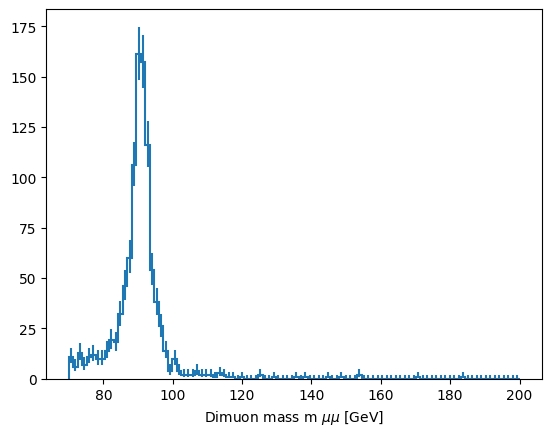

In [35]:
h = (
    hist.Hist.new.Regular(100, 70, 200, name="Dimuon mass m $\mu$$\mu$ [GeV]")
    .Double()
    .fill(ak.flatten(array["Dimuon_mass"], axis = -1))
    .plot()
);

### NumPy and Awkward Arrays
- Let's ask for the mean of the dimuon mass: and check that we get the same result using a NumPy function:

In [36]:
import numpy as np

In [37]:
np.mean(array["Dimuon_mass"])

91.438578125

## Awkward roundtrip

* The multi-threading can be enabled with:
```python
ROOT.ROOT.EnableImplicitMT()
```
* Create a dataframe:

In [38]:
df = ROOT.RDataFrame('Events', 'root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root')

## From RDataFrame to Awkward

Let's take out all 60 mio. data events as an Awkward Array:

In [39]:
array_out = ak.from_rdataframe(
        df,
        columns=(
            "Muon_charge",
            "Muon_eta",
            "Muon_mass",
            "Muon_phi",
            "Muon_pt",
            "nMuon",
        ),
    )

In [40]:
array_out

<Array [{Muon_charge: [...], ...}, ..., {...}] type='61540413 * {Muon_charg...'>

In [41]:
array_out.show(type=True)

type: 61540413 * {
    Muon_charge: var * int32,
    Muon_eta: var * float32,
    Muon_mass: var * float32,
    Muon_phi: var * float32,
    Muon_pt: var * float32,
    nMuon: uint32
}
[{Muon_charge: [-1, -1], Muon_eta: [1.07, -0.564], Muon_mass: [...], ...},
 {Muon_charge: [1, -1], Muon_eta: [-0.428, 0.349], Muon_mass: [...], ...},
 {Muon_charge: [1], Muon_eta: [2.21], Muon_mass: [0.106], Muon_phi: ..., ...},
 {Muon_charge: [1, 1, 1, 1], Muon_eta: [-1.59, ...], Muon_mass: [...], ...},
 {Muon_charge: [-1, -1, 1, 1], Muon_eta: [-2.17, ...], Muon_mass: [...], ...},
 {Muon_charge: [-1, 1, -1], Muon_eta: [-1.37, ...], Muon_mass: [...], ...},
 {Muon_charge: [-1, 1], Muon_eta: [-0.532, -1], Muon_mass: [...], ...},
 {Muon_charge: [1, -1], Muon_eta: [-0.772, ...], Muon_mass: [...], ...},
 {Muon_charge: [-1, 1], Muon_eta: [0.442, 0.702], Muon_mass: [...], ...},
 {Muon_charge: [-1, 1], Muon_eta: [2.34, 2.35], Muon_mass: [...], ...},
 ...,
 {Muon_charge: [1, -1], Muon_eta: [0.252, 0.275], Muon_ma

## From Awkward to RDataFrame
- Let's put the whole array in another RDataFrame as a <b>single</b> column <i>"Events"</i>
    - The large-scale data is not copied:

In [42]:
df1 = ak.to_rdataframe({"Events": array_out})

In [43]:
df1.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            2
Columns from defines        1
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Events          awkward::Record_1M7vRWBynyE     Dataset
awkward_index_  Long64_t                        Define

## Awkward column type
- The `awkward::Record_` type array view records are accessed through functions
- The function names are the same as the original Awkward array record field names: 
    - `Events.nMuon()`, `Events.Muon_pt()`, `Events.Muon_eta()`, `Events.Muon_phi()`, `Events.Muon_mass()`
- They return an iterable object - `ROOT::VecOps::RVec`: an `integer` index can be used to access the elements of the record:
    - `Events.Muon_charge()[0]`
- An `InvariantMass` C++ function can be applied to define a new `Dimuon_mass` column:
```python
df2 = df1.Filter('Events.nMuon() == 2')
         .Filter('Events.Muon_charge()[0] != Events.Muon_charge()[1]')
         .Define('Dimuon_mass',
                 'InvariantMass(Events.Muon_pt(), Events.Muon_eta(), Events.Muon_phi(), Events.Muon_mass())')
         .Filter('Dimuon_mass > 70')
         .Range(1000)
```

In [44]:
df2 = df1.Filter('Events.nMuon() == 2')\
         .Filter('Events.Muon_charge()[0] != Events.Muon_charge()[1]')\
         .Define('Dimuon_mass',\
                 'InvariantMass(Events.Muon_pt(), Events.Muon_eta(), Events.Muon_phi(), Events.Muon_mass())')\
         .Filter('Dimuon_mass > 70')\
         .Range(1000)

In [45]:
df2.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            3
Columns from defines        2
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Dimuon_mass     float                           Define
Events          awkward::Record_1M7vRWBynyE     Dataset
awkward_index_  Long64_t                        Define

In [46]:
print('\nApproximate mass of the Z boson: {:.2f} GeV\n'.format(
        df2.Mean('Dimuon_mass').GetValue()))


Approximate mass of the Z boson: 91.44 GeV



## User-defined C++ lambda functions
Let's define our own `invariant_mass` function that takes an Awkward type:

In [47]:
rdf3 = df1.Filter('Events.nMuon() == 2')\
    .Filter('Events.Muon_charge()[0] != Events.Muon_charge()[1]')\
    .Define("dimuon_mass", """
//
// Let the RDF handle the following selections:
// if (Events.nMuon() == 2) { ...
//    if (Events.Muon_charge()[0] != Events.Muon_charge()[1]) { ...

return std::sqrt(2 * Events.Muon_pt()[0] * Events.Muon_pt()[1]
    * (std::cosh(Events.Muon_eta()[0] - Events.Muon_eta()[1]) 
    - std::cos(Events.Muon_phi()[0] - Events.Muon_phi()[1])));
""")

In [48]:
rdf3.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            3
Columns from defines        2
Event loops run             1
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Events          awkward::Record_1M7vRWBynyE     Dataset
awkward_index_  Long64_t                        Define
dimuon_mass     float                           Define

In [49]:
print('\nApproximate mass of the Z boson: {:.2f} GeV\n'.format(
        rdf3.Filter('dimuon_mass > 70').Range(1000).Mean('dimuon_mass').GetValue()))


Approximate mass of the Z boson: 91.44 GeV



In [50]:
result = ak.from_rdataframe(
    rdf3,
    columns=('dimuon_mass',))

In [51]:
result

<Array [{dimuon_mass: 27.9}, {...}, ..., {...}] type='24067843 * {dimuon_ma...'>

In [52]:
out2 = result[result['dimuon_mass'] > 70]

In [53]:
out2

<Array [{dimuon_mass: 114}, {...}, ..., {...}] type='5638140 * {dimuon_mass...'>

In [54]:
np.mean(out2['dimuon_mass'][:1000])

91.438265625

## User-defined C++ functions

In [55]:
compiler = ROOT.gInterpreter.Declare

In [56]:
done = compiler("""
template<class T>
using Vec = const ROOT::VecOps::RVec<T>;

template <typename T>
T invariant_mass(Vec<T>& pt, Vec<T>& eta, Vec<T>& phi, Vec<T>& mass) {
  const std::size_t size = pt.size();
  
  R__ASSERT(eta.size() == size && phi.size() == size && mass.size() == size);

  T x_sum = 0.; T y_sum = 0.; T z_sum = 0.; T e_sum = 0.;

  for (std::size_t i = 0u; i < size; ++ i) {
  // Convert to (e, x, y, z) coordinate system and update sums
    const auto x = pt[i] * std::cos(phi[i]);
    x_sum += x;

    const auto y = pt[i] * std::sin(phi[i]);
    y_sum += y;

    const auto z = pt[i] * std::sinh(eta[i]);
    z_sum += z;

    e_sum += std::sqrt(x * x + y * y + z * z + mass[i] * mass[i]);
  }

  // Return invariant mass with (+, -, -, -) metric
  return std::sqrt(
      e_sum * e_sum - x_sum * x_sum - y_sum * y_sum - z_sum * z_sum);
}
""")
assert done is True

In [57]:
df4 = df1.Filter('Events.nMuon() == 2')\
         .Filter('Events.Muon_charge()[0] != Events.Muon_charge()[1]')\
         .Define('Dimuon_mass',\
                 'invariant_mass(Events.Muon_pt(), Events.Muon_eta(), Events.Muon_phi(), Events.Muon_mass())')\
         .Filter('Dimuon_mass > 70')\
         .Range(1000)

In [58]:
print('\nApproximate mass of the Z boson: {:.2f} GeV\n'.format(
        df4.Mean('Dimuon_mass').GetValue()))


Approximate mass of the Z boson: 91.44 GeV



## From Awkward to RDataFrame (2)
- The array records can be placed in an RDataFrame as native `ROOT::VecOps::RVec`s:

In [59]:
df3 = ak.to_rdataframe({"ak_Muon_charge": array_out["Muon_charge"], 
                       "ak_Muon_eta": array_out["Muon_eta"], 
                       "ak_Muon_mass": array_out["Muon_mass"],
                       "ak_Muon_phi": array_out["Muon_phi"],
                       "ak_Muon_pt": array_out["Muon_pt"],
                       "ak_nMuon": array_out["nMuon"],
                      })

In [60]:
df3.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            7
Columns from defines        1
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
ak_Muon_charge  ROOT::VecOps::RVec<int32_t>     Dataset
ak_Muon_eta     ROOT::VecOps::RVec<float>       Dataset
ak_Muon_mass    ROOT::VecOps::RVec<float>       Dataset
ak_Muon_phi     ROOT::VecOps::RVec<float>       Dataset
ak_Muon_pt      ROOT::VecOps::RVec<float>       Dataset
ak_nMuon        uint32_t                        Dataset
awkward_index_  Long64_t                        Define

In [61]:
df4 = df3.Filter('ak_nMuon == 2')\
       .Filter('ak_Muon_charge[0] != ak_Muon_charge[1]')\
       .Define('ak_Dimuon_mass', 'invariant_mass(ak_Muon_pt, ak_Muon_eta, ak_Muon_phi, ak_Muon_mass)')\
       .Filter('ak_Dimuon_mass > 70')\
       .Range(1000)

In [62]:
df4.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            8
Columns from defines        2
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
ak_Dimuon_mass  float                           Define
ak_Muon_charge  ROOT::VecOps::RVec<int32_t>     Dataset
ak_Muon_eta     ROOT::VecOps::RVec<float>       Dataset
ak_Muon_mass    ROOT::VecOps::RVec<float>       Dataset
ak_Muon_phi     ROOT::VecOps::RVec<float>       Dataset
ak_Muon_pt      ROOT::VecOps::RVec<float>       Dataset
ak_nMuon        uint32_t                        Dataset
awkward_index_  Long64_t                        Define

In [63]:
print('\nApproximate mass of the Z boson: {:.2f} GeV\n'.format(
        df4.Mean('ak_Dimuon_mass').GetValue()))


Approximate mass of the Z boson: 91.44 GeV



## Summary
- Awkward Arrays and RDataFrame provide two very different ways of performing large scale
    - By adding the ability to convert between them, users get the best of both
- The Awkward-RDF bridge provides users with more flexibility in mixing different packages and languages in their analyses
    - It is a part of Awkward version 2
- Awkward version 2 will be fully released at the beginning of December 2022
    - The time line [here](https://github.com/scikit-hep/awkward/wiki)

### Feedback is greatly appreciated! Please, report issues [here](https://github.com/scikit-hep/awkward/issues). 